# Algorithmic Trading Model for Simple Trend-Following Strategy Using Python Take 2
### David Lowe
### January 6, 2021

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This algorithmic trading model examines a simple trend-following strategy for a stock. The model buys a stock when the price reaches the highest price for the last X number of days. The model will exit the position when the stock price crosses below the mean of the same window size.

In this Take1 iteration, we will set up the models using one fixed window size for each model. The window size will vary from 10 to 50 trading days at a 5-day increment.

ANALYSIS: From this iteration, we analyzed the stock prices for Apple Inc. (AAPL) between January 1, 2019, and December 24, 2020. The trading model produced a profit of 79.07 dollars per share. The buy-and-hold approach yielded a gain of 90.18 dollars per share.

CONCLUSION: For the stock of AAPL during the modeling time frame, the trading strategy did not produce a better return than the buy-and-hold approach. We should consider modeling this stock further by experimenting with more variations of the strategy.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Implement and Train Models
4. Back-test Models
5. Evaluate Strategy Performance

## Task 1 - Prepare Environment

In [1]:
# # Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
#
# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# # Retrieve the CPU information
# ncpu = !nproc
# print("The number of available CPUs is:", ncpu[0])

### 1.a) Load libraries and modules

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from datetime import date, datetime, timedelta
import requests
import json
from dotenv import load_dotenv
# import pandas_datareader.data as pdr

# Begin the timer for the script processing
startTimeScript = datetime.now()

### 1.b) Set up the controlling parameters and functions¶

In [6]:
# Specify the key modeling parameters below
STOCK_SYMBOL = 'AAPL'
INITIAL_CAPITAL = 0

# Specify the moving average parameters for the trading strategy
WINDOW_MIN = 10
WINDOW_MAX = 50
WINDOW_INCREMENT = 5
VOL_MA_MIN = 10
VOL_MA_MAX = 10
VOL_MA_INCREMENT = 1

# The number of extra days of data we need for calculating moving averages (usually equals to the largest value of slow MA)
EXTRA_DAYS = WINDOW_MAX

MODEL_START_DATE = date(2019, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

MODEL_END_DATE = datetime.now().date()
# MODEL_END_DATE = date(2020, 11, 20)
print("Ending date for the model:", MODEL_END_DATE)

# data_start_date = MODEL_START_DATE
data_start_date = MODEL_START_DATE - timedelta(days=int(EXTRA_DAYS * 1.5)) # Need more pricing data to calculate moving averages
print("First date of data we need for modeling:", data_start_date)

data_end_date = MODEL_END_DATE
print("Last date of data we need for modeling:", data_end_date)

Starting date for the model: 2019-01-01
Ending date for the model: 2020-12-20
First date of data we need for modeling: 2018-10-18
Last date of data we need for modeling: 2020-12-20


In [7]:
# Specify the script running parameters below

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

# Configure the plotting style
plt.style.use('seaborn')

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose_signals = False
verbose_models = True
verbose_graphs = True
verbose_portfolios = True
verbose_transactions = True
verbose_positions = True

In [8]:
# Set up the parent directory location for loading the dotenv files

# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up access to the dotenv file on local PC
env_path = "/Users/david/PycharmProjects/"
dotenv_path = env_path + "python_script.env"
load_dotenv(dotenv_path=dotenv_path)

True

## Task 2 - Acquire and Pre-Process Data

In [9]:
# Set up the data service provider and data acquisition parameters
data_service = 'Quandl'

# Check and see whether the API key is available
api_key = os.environ.get('QUANDL_API')
if api_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

start_date_string = data_start_date.strftime('%Y-%m-%d')
end_date_string = data_end_date.strftime('%Y-%m-%d')
api_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, STOCK_SYMBOL, api_key)
response = requests.get(api_url)
resp_dict = json.loads(response.text)
stock_rawdata = pd.DataFrame(resp_dict['datatable']['data'])
print(len(stock_rawdata), 'data points retrieved from the API call.')

547 data points retrieved from the API call.


In [10]:
stock_rawdata.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
# stock_rawdata.set_index('date', inplace=True)
stock_rawdata.index = pd.to_datetime(stock_rawdata.date)
stock_pricing = stock_rawdata.sort_index(ascending=True)
print(stock_pricing.head())
print()
print(stock_pricing.tail())

           ticker        date    open    high     low   close       volume  dividend  closeunadj lastupdated
date                                                                                                        
2018-10-18   AAPL  2018-10-18  54.465  54.935  53.250  54.005  130325260.0       0.0      216.02  2020-08-31
2018-10-19   AAPL  2018-10-19  54.515  55.315  54.358  54.828  132314904.0       0.0      219.31  2020-08-31
2018-10-22   AAPL  2018-10-22  54.947  55.840  54.735  55.163  115168328.0       0.0      220.65  2020-08-31
2018-10-23   AAPL  2018-10-23  53.958  55.813  53.675  55.682  155071384.0       0.0      222.73  2020-08-31
2018-10-24   AAPL  2018-10-24  55.650  56.057  53.635  53.773  163700652.0       0.0      215.09  2020-08-31

           ticker        date    open    high      low    close       volume  dividend  closeunadj lastupdated
date                                                                                                          
2020-12-14   A

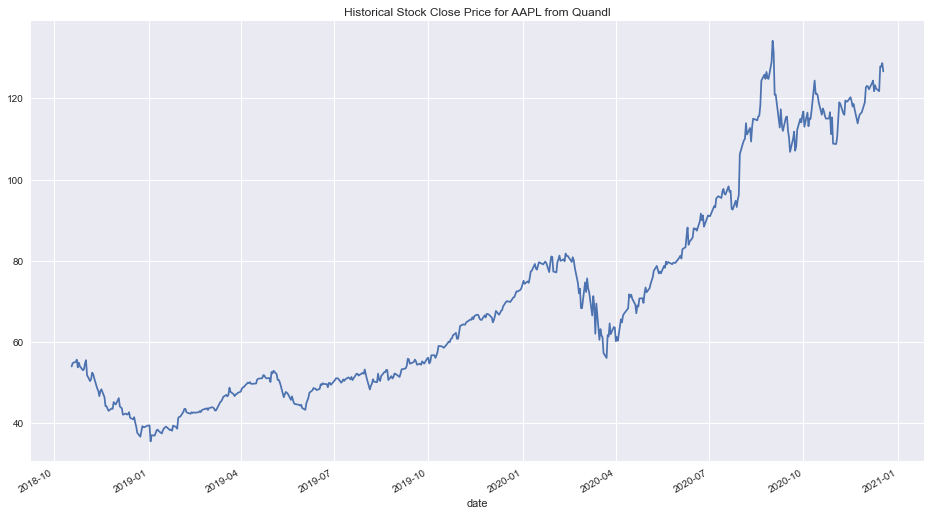

In [11]:
# Set up the standard column name for modeling
# Column names may be data-provider specific!
MODEL_TEMPLATE = stock_pricing.loc[:, ['open','close','volume']]
MODEL_TEMPLATE.rename(columns={'open': 'open_price', 'close': 'close_price', 'volume': 'trading_volume'}, inplace=True)
plot_title = 'Historical Stock Close Price for ' + STOCK_SYMBOL + ' from ' + data_service
MODEL_TEMPLATE['close_price'].plot(figsize=(16,9), title=plot_title)
plt.show()

## Task 3 - Implement and Train Models

In [12]:
# Define the function that will generate the indicators and trading signals
def populate_signals(window=WINDOW_MIN, vol_ma=VOL_MA_MIN):

    trade_model = MODEL_TEMPLATE.copy()
    trade_model['window_high'] = trade_model['close_price'].shift(1).rolling(window=window).max()
    trade_model['window_low'] = trade_model['close_price'].shift(1).rolling(window=window).min()
    trade_model['window_avg'] = trade_model['close_price'].shift(1).rolling(window=window).mean()
    trade_model['volume_ma'] = trade_model['trading_volume'].rolling(vol_ma).mean()
    trade_model['trade_signal'] = 0
    trade_model['entry_exit'] = 0
    prior_signal = 0
    prior_ownership = False
    currently_own = False

    # Truncate the model to the required starting and ending dates
    trade_model = trade_model[MODEL_START_DATE:MODEL_END_DATE]

    for k in range(len(trade_model)):
        current_signal = 0
        breakout = trade_model.at[trade_model.index[k],'close_price'] - trade_model.at[trade_model.index[k],'window_high']
        crossover = trade_model.at[trade_model.index[k],'close_price'] - trade_model.at[trade_model.index[k],'window_avg']
        trade_volume = trade_model.at[trade_model.index[k],'trading_volume']
        average_volume = trade_model.at[trade_model.index[k],'volume_ma']
        trade_model.at[trade_model.index[k],'entry_exit'] = prior_signal
        if prior_signal == 1:
            currently_own = True
        elif  prior_signal == -1:
            currently_own = False
        else:
            currently_own = prior_ownership

        if (breakout > 0) and (trade_volume > average_volume) and (not currently_own):
            current_signal = 1  # trade_signal = 1 means we should buy
            currently_own = True
        elif (crossover < 0) and (trade_volume > average_volume) and currently_own:
            current_signal = -1  # trade_signal = -1 means we should sell
            currently_own = False
        trade_model.at[trade_model.index[k],'trade_signal'] = current_signal
        prior_signal = current_signal
        prior_ownership = currently_own

    # Exiting the position on the last day of modeling period
    if currently_own:
        trade_model.at[trade_model.index[-1],'entry_exit'] = -1
    if verbose_signals: print(trade_model, '\n')
    return trade_model

In [13]:
# Build the collection of trading models by iterating through the parameters
trading_model_collection = {}
serial_no = 0
for window_size in range(WINDOW_MIN, WINDOW_MAX+1, WINDOW_INCREMENT):
    for vol_average in range(VOL_MA_MIN, VOL_MA_MAX+1, VOL_MA_INCREMENT):
        serial_no += 1
        model_tag = 'Model_' + str(serial_no).zfill(3) + '_WINDOW_' + str(window_size).zfill(2) + '_VOLMA_' + str(vol_average).zfill(2)
        if verbose_signals: print('Processing model:', model_tag)
        trading_model = populate_signals(window_size, vol_average)
        trading_model_collection[model_tag] = trading_model.copy()
print(len(trading_model_collection), 'trading models generated!')

9 trading models generated!


In [14]:
# List the entry/exit points for each model
def list_model_entry_exit(trade_model):
    print(trade_model[(trade_model['trade_signal'] != 0) | (trade_model['entry_exit'] != 0)])

In [15]:
if verbose_models:
    for model_name in trading_model_collection:
        print('List the signal changes and entry/exit points for model:', model_name)
        list_model_entry_exit(trading_model_collection[model_name])
        print()

List the signal changes and entry/exit points for model: Model_001_WINDOW_10_VOLMA_10
            open_price  close_price  trading_volume  window_high  window_low  window_avg    volume_ma  trade_signal  entry_exit
date                                                                                                                           
2019-01-25      38.870       39.440     134191572.0       39.205      37.500     38.4174  117931448.8             1           0
2019-01-28      38.947       39.075     104768232.0       39.440      37.500     38.5164  117598975.6             0           1
2019-03-07      43.468       43.125      99185496.0       43.962      42.765     43.5370   93029630.0            -1           0
2019-03-08      42.580       43.227      95997432.0       43.962      43.125     43.5730   95064111.6             0          -1
2019-03-11      43.873       44.725     128044136.0       43.962      43.125     43.5715   99119182.0             1           0
2019-03-12      45

In [16]:
def draw_model_graph(trade_model, mdl_name=STOCK_SYMBOL):
    graph_data = trade_model.copy()
    title_string = 'Moving Average Crossover Momentum Trading Model for ' + mdl_name
    fig = plt.figure(figsize=(16,9))
    ylabel = STOCK_SYMBOL + ' price in $'
    ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
    graph_data['close_price'].plot(ax=ax1, color='g')
    ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
    ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
    plt.legend(loc='upper left')
    plt.show()

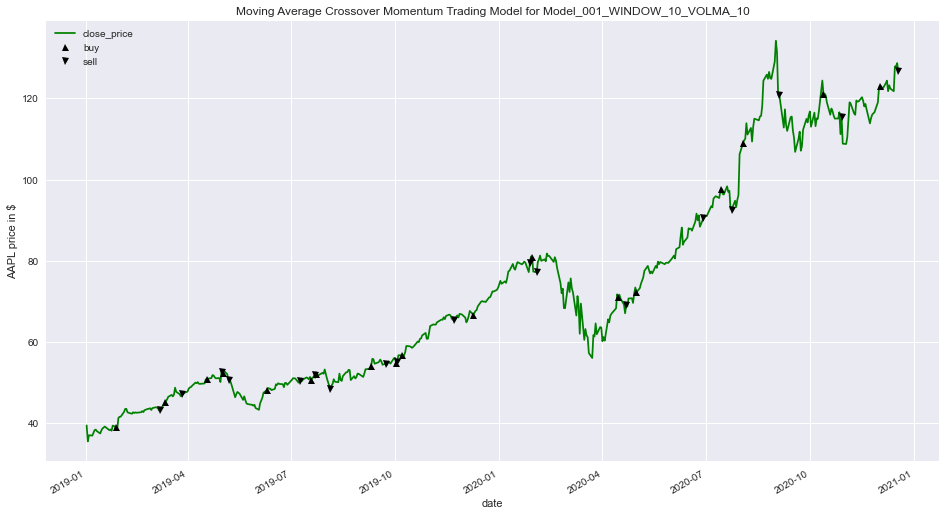

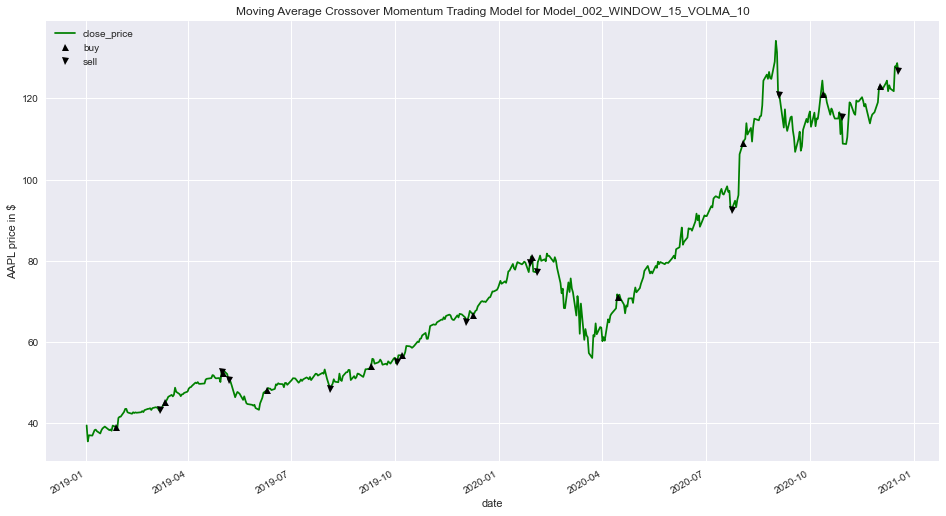

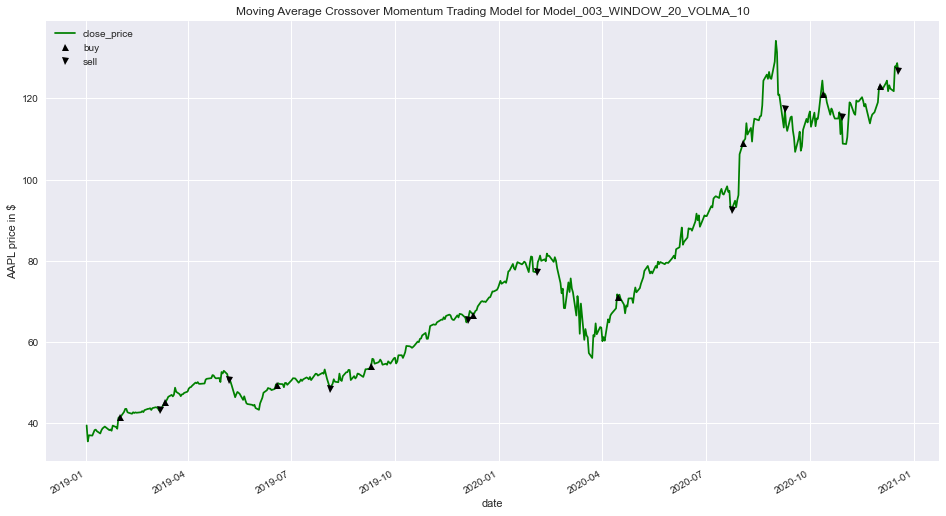

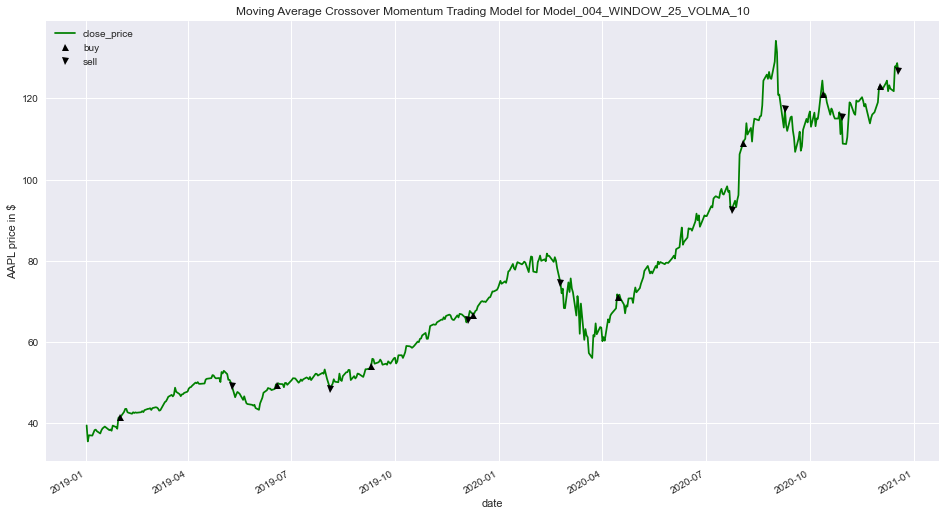

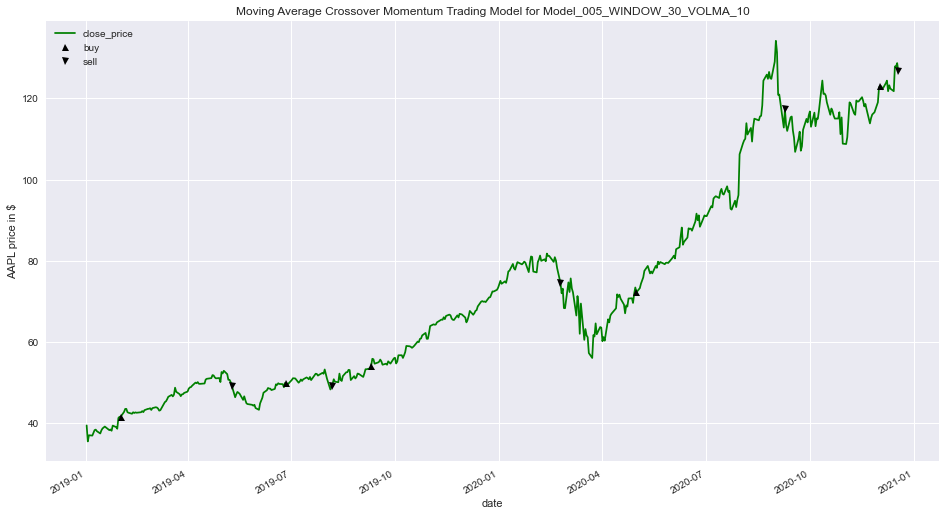

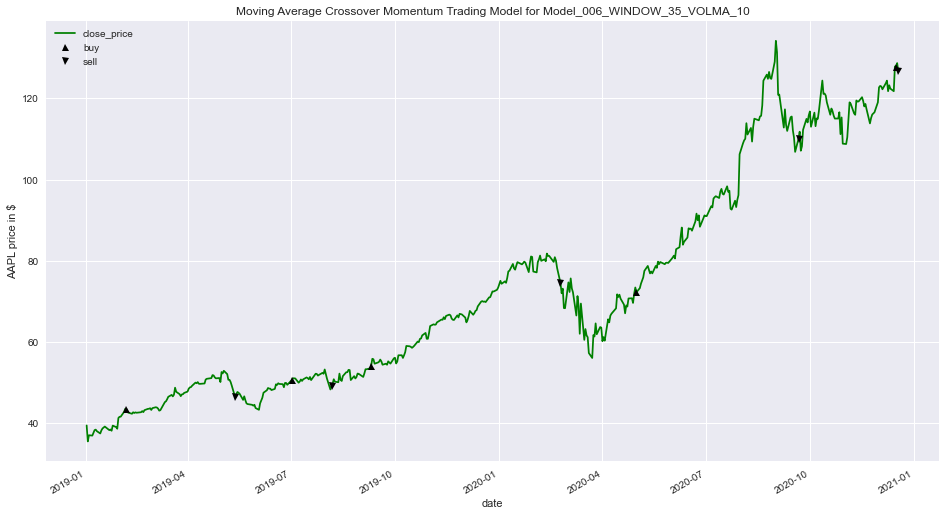

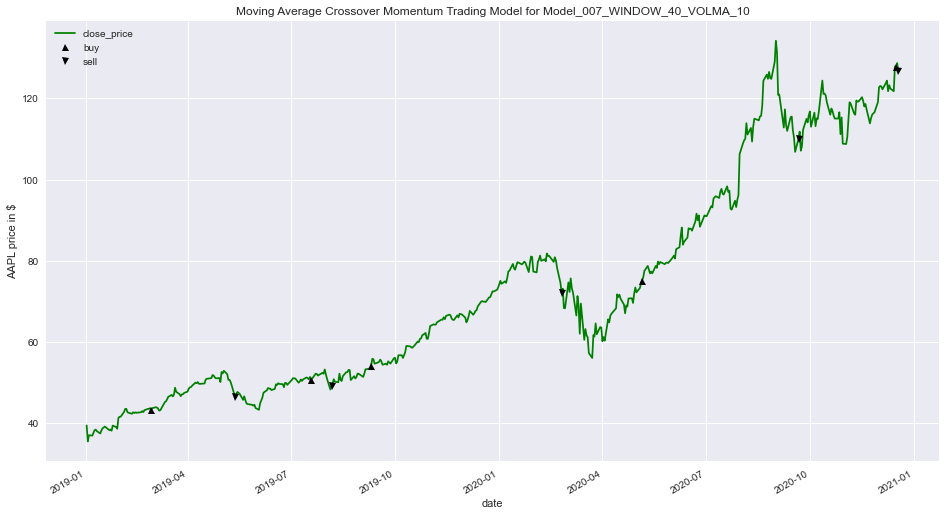

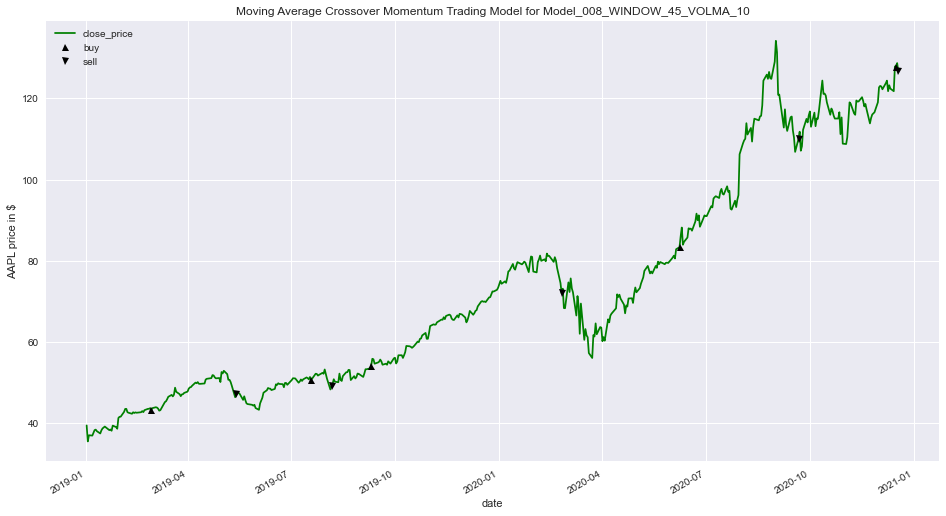

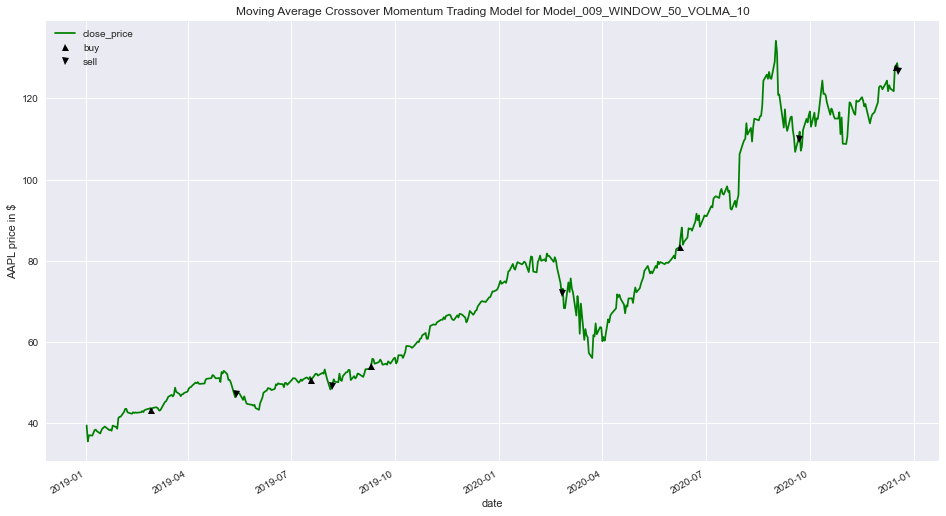

In [17]:
if verbose_graphs:
    for model_name in trading_model_collection:
        draw_model_graph(trading_model_collection[model_name], model_name)

## Task 4 - Back-test Models

In [18]:
def generate_trading_portfolios(trade_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trade_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction', 'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accum_return'])
    portfolio.iloc[0]['trade_action'] = 0
    portfolio.iloc[0]['qty_onhand'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['sold_transaction'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['cash_onhand'] = INITIAL_CAPITAL
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_position'] = INITIAL_CAPITAL
    portfolio.iloc[0]['accum_return'] = portfolio.iloc[0]['total_position'] - INITIAL_CAPITAL
    recent_cost = 0

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        if (trade_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
            portfolio.iloc[i]['trade_action'] = 1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
            recent_cost = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            if verbose_portfolios: print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        elif (trade_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
            portfolio.iloc[i]['trade_action'] = -1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = 0.00
            portfolio.iloc[i]['sold_transaction'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
            portfolio.iloc[i]['gain_loss'] = (recent_cost + (trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
            recent_cost = 0.00
            if verbose_portfolios: print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        else:
            portfolio.iloc[i]['trade_action'] = 0
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
        portfolio.iloc[i]['position_value'] = trade_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
        portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accum_return'] = portfolio.iloc[i]['total_position'] - INITIAL_CAPITAL

    if verbose_portfolios: print('\n', portfolio, '\n')
    return portfolio

In [19]:
def calculate_positions_and_performance(trade_model):
    trade_positions = generate_trading_portfolios(trade_model)
    trade_transactions = trade_positions[trade_positions['trade_action'] != 0]
    if verbose_transactions: print(trade_transactions)
    if verbose_transactions:
        if trade_transactions.iloc[-1]['trade_action'] == 1:
            print('The current status of the model is:', 'Holding a position since', trade_transactions.index.tolist()[-1].date(), '\n')
        else:
            print('The current status of the model is:', 'Waiting to enter since', trade_transactions.index.tolist()[-1].date(), '\n')
    return trade_positions

In [20]:
# Convert trading models into positions and calculate profit and loss
# Initialize a dictionary for tracking positions for all models
model_positions_colletion={}

for model_name in trading_model_collection:
    if verbose_portfolios: print('Processing the positions for model:', model_name)
    model_positions_colletion[model_name] = calculate_positions_and_performance(trading_model_collection[model_name])
print(len(model_positions_colletion), 'sets of model positions generated.')

Processing the positions for model: Model_001_WINDOW_10_VOLMA_10
BOUGHT QTY: 1 on 2019-01-28 00:00:00 at the price of 38.947
SOLD QTY: -1 on 2019-03-08 00:00:00 at the price of 42.58
BOUGHT QTY: 1 on 2019-03-12 00:00:00 at the price of 45.0
SOLD QTY: -1 on 2019-03-27 00:00:00 at the price of 47.188
BOUGHT QTY: 1 on 2019-04-18 00:00:00 at the price of 50.78
SOLD QTY: -1 on 2019-05-01 00:00:00 at the price of 52.47
BOUGHT QTY: 1 on 2019-05-02 00:00:00 at the price of 52.46
SOLD QTY: -1 on 2019-05-08 00:00:00 at the price of 50.475
BOUGHT QTY: 1 on 2019-06-10 00:00:00 at the price of 47.953
SOLD QTY: -1 on 2019-07-09 00:00:00 at the price of 49.8
BOUGHT QTY: 1 on 2019-07-19 00:00:00 at the price of 51.447
SOLD QTY: -1 on 2019-07-22 00:00:00 at the price of 50.913
BOUGHT QTY: 1 on 2019-07-23 00:00:00 at the price of 52.115
SOLD QTY: -1 on 2019-08-05 00:00:00 at the price of 49.498
BOUGHT QTY: 1 on 2019-09-10 00:00:00 at the price of 53.465
SOLD QTY: -1 on 2019-09-23 00:00:00 at the price o

In [21]:
# Initialize a dataframe for storing the model's profit and loss
model_performance_summary = pd.DataFrame(columns=['Model_name','Return_value','Return_percentage'])
for model_name in model_positions_colletion:
    if verbose_positions: print('Processing positions for model:', model_name)
    if verbose_positions: print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model_positions_colletion[model_name].accum_return[-1]))
    if INITIAL_CAPITAL != 0:
        return_percentage = model_positions_colletion[model_name].accum_return[-1] / INITIAL_CAPITAL * 100
        if verbose_positions: print('Accumulated return percentage based on the initial capital investment: %.2f%%' % return_percentage)
    else:
        return_percentage = None
    if verbose_positions: print()
    model_performance_summary = model_performance_summary.append({'Model_name': model_name, 'Return_value': model_positions_colletion[model_name].accum_return[-1], 'Return_percentage': return_percentage}, ignore_index=True)
    model_performance_summary.sort_values(by=['Return_value'], inplace=True, ascending=False)

print(len(model_performance_summary), 'profit/loss summaries generated.\n')
print('The top ten model\'s performance summary:')
print(model_performance_summary.head(10))

Processing positions for model: Model_001_WINDOW_10_VOLMA_10
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $32.47

Processing positions for model: Model_002_WINDOW_15_VOLMA_10
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $52.70

Processing positions for model: Model_003_WINDOW_20_VOLMA_10
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $49.97

Processing positions for model: Model_004_WINDOW_25_VOLMA_10
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $49.51

Processing positions for model: Model_005_WINDOW_30_VOLMA_10
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $80.11

Processing positions for model: Model_006_WINDOW_35_VOLMA_10
Accumulated profit/loss for one share of stock with initial capital o

## Task 5 - Evaluate Strategy Performance

In [22]:
# Calculate the stock's performance for a buy-and-hold model
top_model_name = model_performance_summary.loc[0]['Model_name']
top_trading_model = trading_model_collection[top_model_name]
print('The entry point for the buy-and-hold model: $%.2f on %s' % (top_trading_model.iloc[0]['open_price'], top_trading_model.index[0].date()))
print('The exit point for the buy-and-hold model: $%.2f on %s' % (top_trading_model.iloc[-1]['open_price'], top_trading_model.index[-1].date()))
print('The performance of the buy-and-hold model: $%.2f' %(top_trading_model.iloc[-1]['open_price'] - top_trading_model.iloc[0]['open_price']))
print('The performance of the top trading model: $%.2f' %(model_performance_summary.iloc[0]['Return_value']))

The entry point for the buy-and-hold model: $38.72 on 2019-01-02
The exit point for the buy-and-hold model: $128.96 on 2020-12-18
The performance of the buy-and-hold model: $90.24
The performance of the top trading model: $80.11


In [23]:
top_model_positions = model_positions_colletion[top_model_name]
print(top_model_positions[top_model_positions['trade_action'] != 0])

           trade_action qty_onhand cost_basis sold_transaction gain_loss cash_onhand position_value total_position accum_return
date                                                                                                                           
2019-02-01            1          1      41.74                0         0      -41.74          41.63          -0.11        -0.11
2019-05-10           -1          0          0           49.355     7.615       7.615              0          7.615        7.615
2019-06-27            1          1     50.072                0         0     -42.457         49.935          7.478        7.478
2019-08-06           -1          0          0           49.078    -0.994       6.621              0          6.621        6.621
2019-09-10            1          1     53.465                0         0     -46.844         54.175          7.331        7.331
2020-02-24           -1          0          0           74.315     20.85      27.471              0     

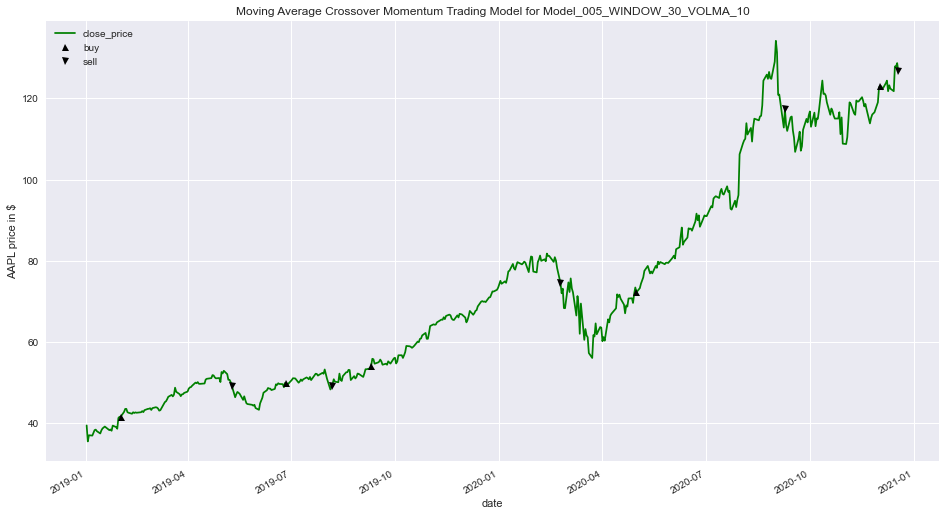

In [24]:
draw_model_graph(trading_model_collection[top_model_name], top_model_name)

In [25]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:09.993650
